In [1]:
import dill
import numpy as np
import ROOT

In [2]:
#Look at branches in pickle file

with open(f'axo_emu_branches_2024F.pkl', 'rb') as file:
    branches = dill.load(file)
    print(branches)

{'e_mu_mass_DST_PFScouting_AXONominal': <Array [14.5, 11.2, 4.25, 50.3, ..., 11.3, 36.8, 11.7] type='268057 * float64'>, 'e_mu_mass_DST_PFScouting_AXOTight': <Array [11.2, 4.25, 6.21, 7.14, ..., 10.8, 11.3, 36.8] type='90434 * float64'>, 'e_mu_mass_DST_PFScouting_AXOVTight': <Array [25.8, 4.34, 90.9, 15.8, ..., 27.2, 8.55, 4.43] type='157 * float64'>, 'e_mu_mass_DST_PFScouting_ZeroBias': <Array [3.58, 22.1, 22.9, 17.6, ..., 11, 8.04, 31.4] type='765763 * float64'>, 'e_pt_DST_PFScouting_AXONominal': <Array [9.19, 6.66, 4.77, 5.3, ..., 7.64, 8.07, 4.17] type='268057 * float64'>, 'e_pt_DST_PFScouting_AXOTight': <Array [6.66, 4.77, 4.6, 5, ..., 5.5, 4.14, 7.64, 8.07] type='90434 * float64'>, 'e_pt_DST_PFScouting_AXOVTight': <Array [5.61, 4.07, 9.53, 24, ..., 7.11, 34.3, 4.28, 6.75] type='157 * float64'>, 'e_pt_DST_PFScouting_ZeroBias': <Array [4.04, 6.03, 5.15, 4.41, ..., 4.97, 4.73, 5.56] type='765763 * float64'>, 'mu_pt_DST_PFScouting_AXONominal': <Array [5.52, 7.77, 3.05, 16.7, ..., 4.1

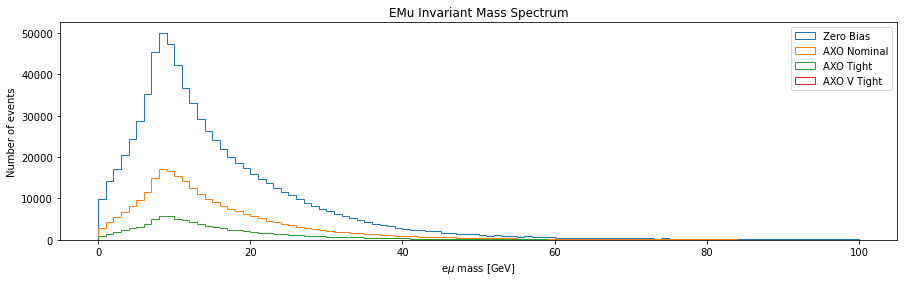

In [3]:
#Look at emu invariant mass spectrum

import matplotlib.pyplot as plt
mass_axonominal = branches["e_mu_mass_DST_PFScouting_AXONominal"]
mass_axotight = branches["e_mu_mass_DST_PFScouting_AXOTight"]
mass_axovtight = branches["e_mu_mass_DST_PFScouting_AXOVTight"]
mass_zerobias = branches["e_mu_mass_DST_PFScouting_ZeroBias"]

plt.figure(figsize=(15,4))
plt.hist(mass_zerobias,100,(0,100),histtype='step',label='Zero Bias')
plt.hist(mass_axonominal,100,(0,100),histtype='step',label='AXO Nominal')
plt.hist(mass_axotight,100,(0,100),histtype='step',label='AXO Tight')
plt.hist(mass_axovtight,100,(0,100),histtype='step',label='AXO V Tight')
plt.legend()
plt.xlabel(r"e$\mu$ mass [GeV]")
plt.ylabel("Number of events")
plt.title("EMu Invariant Mass Spectrum")     
plt.show()

In [5]:
var_names = [
    "e_mu_mass",
    "e_pt",
    "mu_pt"
]

trigger_names = [
    "DST_PFScouting_AXONominal",
    "DST_PFScouting_AXOTight",
    "DST_PFScouting_AXOVTight",
    "DST_PFScouting_ZeroBias"
]

In [6]:
branch_names = list(branches.keys())

# Open a ROOT file
output_file = ROOT.TFile("emu_branches_2024F.root", "RECREATE")

# Create buffers to hold the data for each branch
branch_buffers = {}
for i in range(len(branch_names)):
    branch_buffers[branch_names[i]] = np.zeros(1, dtype="float64")
    
for trigger_name in trigger_names:
    tree = ROOT.TTree(f"Events_{trigger_name}", f"Events_{trigger_name}")
    
    for i in range(len(var_names)):
        branch_name = f"{var_names[i]}_{trigger_name}"
        tree.Branch(branch_name, branch_buffers[branch_name], f"{branch_name}/D")
    
    n_events = len(branches[f"e_mu_mass_{trigger_name}"])
    
    for i in range(n_events):
        for j in range(len(var_names)):
            branch_name = f"{var_names[j]}_{trigger_name}"
            branch_buffers[branch_name][0] = branches[branch_name][i]
        tree.Fill()
        
    tree.Write()
    
output_file.Close()

In [7]:
file = ROOT.TFile.Open("emu_branches_2024F.root") 
tree_name = None
for key in file.GetListOfKeys():
    obj = key.ReadObj()
    if isinstance(obj, ROOT.TTree):
        tree_name = obj.GetName()
        print(f"Found TTree: {tree_name}")
        break

if tree_name:
    tree = file.Get(tree_name)

    # List all branches
    print("Branches in the TTree:")
    for branch in tree.GetListOfBranches():
        print(f"  - {branch.GetName()}")

    # Get the number of entries (events)
    num_events = tree.GetEntries()
    print(f"\nNumber of events (entries) in the TTree: {num_events}")
    
    
    
# Get the TTree
tree_name = "Events_DST_PFScouting_AXONominal"  # Replace with your TTree name
tree = file.Get(tree_name)

# Define the branch and threshold
branch_name = "e_mu_mass_DST_PFScouting_AXONominal"
threshold = 20.0  # Replace with your threshold value

# Loop through the events and count entries above the threshold
count = 0
for entry in tree:
    value = getattr(entry, branch_name)
    if value > threshold:
        count += 1

print(f"Number of entries in {branch_name} above {threshold}: {count}")


Found TTree: Events_DST_PFScouting_AXONominal
Branches in the TTree:
  - e_mu_mass_DST_PFScouting_AXONominal
  - e_pt_DST_PFScouting_AXONominal
  - mu_pt_DST_PFScouting_AXONominal

Number of events (entries) in the TTree: 268057
Number of entries in e_mu_mass_DST_PFScouting_AXONominal above 20.0: 69274


In [8]:
ROOT.gStyle.SetTitleSize(0.05, "X")
ROOT.gStyle.SetTitleSize(0.05, "Y")

In [9]:
def sliding_window_fit(mass, width, alpha1, alpha2, n1, n2):  
    if mass<15:
        tree = file.Get("Events_DST_PFScouting_AXONominal")
        xvar = ROOT.RooRealVar("e_mu_mass_DST_PFScouting_AXONominal", "e_mu_mass_DST_PFScouting_AXONominal", mass-4*width, mass+4*width)
        dataset = ROOT.RooDataSet('dataset', 'Data', tree, ROOT.RooArgSet(xvar))

        mean  = ROOT.RooRealVar('mean', 'mean', mass)
        sigma = ROOT.RooRealVar('sigma', 'sigma', width)

        signal_model = ROOT.RooGaussian('signal', 'Signal Model', xvar, mean, sigma)

        alpha = ROOT.RooRealVar('alpha', 'alpha', -2, -10., 0.)
        background_model = ROOT.RooExponential('background','Background Model',xvar,alpha)

        signal_yield = ROOT.RooRealVar('signal_yield', 'Signal Yield', 0, -dataset.numEntries(), dataset.numEntries())
        background_yield = ROOT.RooRealVar('background_yield', 'Background Yield', dataset.numEntries(), 0, dataset.numEntries())
        model = ROOT.RooAddPdf('model', 'Fit Model', ROOT.RooArgList(signal_model, background_model), ROOT.RooArgList(signal_yield, background_yield))
        background_only_model = ROOT.RooAddPdf('background_only_model', 'Background Only Model', ROOT.RooArgList(background_model), ROOT.RooArgList(background_yield))


        # Fit model to dataset
        xvar.setRange("fitrange", mass-4*width, mass+4*width)

        fit_result_B = background_only_model.fitTo(dataset, ROOT.RooFit.Save(), Range="fitrange", PrintLevel=-1)
        logL_B = fit_result_B.minNll()  # Get -log(Likelihood) for background-only fit

        fit_result = model.fitTo(dataset, ROOT.RooFit.Save(), Range="fitrange", PrintLevel=-1)
        logL_SB = fit_result.minNll()
        fit_params = fit_result.floatParsFinal()

        likelihood_ratio = 2 * (logL_B - logL_SB)

        print(f"Likelihood Ratio Test Statistic: λ = {likelihood_ratio:.2f}")
        print(f"Local signifiance: {(likelihood_ratio**.5):.2f} sigma")

        # Plot data and model on RooFit frame
        frame = xvar.frame(ROOT.RooFit.Title('EMu Signal + Background Fit'))
        dataset.plotOn(frame)
        model.plotOn(frame)
        model.plotOn(frame,ROOT.RooFit.Components(ROOT.RooArgSet(signal_model)), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kBlue))
        model.plotOn(frame,ROOT.RooFit.Components(ROOT.RooArgSet(background_model)), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kRed))

        # Plot frame on canvas like normal ROOT plot
        c = ROOT.TCanvas('c', 'Fitting Example', 800, 600)
        frame.Draw()
        leg = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
        # To get these names you can do ROOT.gPad.ls() to find the names Roofit gives the objects
        leg.AddEntry('h_dataset', dataset.GetTitle(), 'PE')
        model_entry = leg.AddEntry('model_Norm[Bmass]', model.GetTitle(), 'L')
        model_entry.SetLineColor(ROOT.kBlue)
        signal_entry = leg.AddEntry('model_Norm[Bmass]_Comp[signal]', signal_model.GetTitle(), 'L')
        signal_entry.SetLineColor(ROOT.kBlue)
        signal_entry.SetLineStyle(ROOT.kDashed)
        background_entry = leg.AddEntry('model_Norm[Bmass]_Comp[background]', background_model.GetTitle(), 'L')
        background_entry.SetLineColor(ROOT.kRed)
        background_entry.SetLineStyle(ROOT.kDashed)
        leg.Draw()
        #c.SaveAs(f'signal+background.png')

        chi2 = frame.chiSquare(nFitParam=3)
        print("Chi^2/dof = ", chi2)

        #background_integral = background_model.createIntegral(ROOT.RooArgSet(xvar), ROOT.RooFit.NormSet(ROOT.RooArgSet(xvar)), ROOT.RooFit.Range("fitrange"))
        #effective_background_yield = background_yield.getVal() * background_integral.getVal()
        #print(effective_background_yield)

        # Print out fit parameter results
        #print('Final Fit Results')
        #for param in fit_params:
        #    print(f'{param.GetName()} = {param.getVal()}')
   
    else:
        tree = file.Get("Events_DST_PFScouting_AXONominal")
        xvar = ROOT.RooRealVar("e_mu_mass_DST_PFScouting_AXONominal", "e_mu_mass_DST_PFScouting_AXONominal", mass-4*width, mass+4*width)
        #xvar = ROOT.RooRealVar("e_mu_mass_DST_PFScouting_AXONominal", "e_mu_mass_DST_PFScouting_AXONominal", 5, 50)
        dataset = ROOT.RooDataSet('dataset', 'Data', tree, ROOT.RooArgSet(xvar))

        # Define double gaussian as signal model
        mean  = ROOT.RooRealVar('mean', 'Mean', mass)
        sigma = ROOT.RooRealVar('sigma', 'Sigma', width)
        alpha_l = ROOT.RooRealVar('alpha_l', 'Alpha (Left Tail Shift)', alpha1)
        n_l = ROOT.RooRealVar('n_l', 'N (Tail Shape)', n1)
        alpha_r = ROOT.RooRealVar('alpha_r', 'Alpha (Right Tail Shift)', alpha2)
        n_r = ROOT.RooRealVar('n_r', 'N (Tail Shape)', n2)
        signal_model = ROOT.RooCrystalBall('signal', 'Crystal Ball Signal Model', xvar, mean, sigma, alpha_l, n_l, alpha_r, n_r)

        alpha = ROOT.RooRealVar('alpha', 'alpha', -2, -10., 0.)
        background_model = ROOT.RooExponential('background','Background Model',xvar,alpha)

        signal_yield = ROOT.RooRealVar('signal_yield', 'Signal Yield', 0, -dataset.numEntries(), dataset.numEntries())
        background_yield = ROOT.RooRealVar('background_yield', 'Background Yield', dataset.numEntries(), 0, dataset.numEntries())
        model = ROOT.RooAddPdf('model', 'Fit Model', ROOT.RooArgList(signal_model, background_model), ROOT.RooArgList(signal_yield, background_yield))
        background_only_model = ROOT.RooAddPdf('background_only_model', 'Background Only Model', ROOT.RooArgList(background_model), ROOT.RooArgList(background_yield))


        # Fit model to dataset
        xvar.setRange("fitrange", mass-4*width, mass+4*width)

        fit_result_B = background_only_model.fitTo(dataset, ROOT.RooFit.Save(), Range="fitrange", PrintLevel=-1)
        logL_B = fit_result_B.minNll()  # Get -log(Likelihood) for background-only fit

        fit_result = model.fitTo(dataset, ROOT.RooFit.Save(), Range="fitrange", PrintLevel=-1)
        logL_SB = fit_result.minNll()
        fit_params = fit_result.floatParsFinal()

        likelihood_ratio = 2 * (logL_B - logL_SB)

        print(f"Likelihood Ratio Test Statistic: λ = {likelihood_ratio:.2f}")
        print(f"Local signifiance: {(likelihood_ratio**.5):.2f} sigma")

        # Plot data and model on RooFit frame
        frame = xvar.frame(ROOT.RooFit.Title('EMu Signal + Background Fit'))
        dataset.plotOn(frame)
        model.plotOn(frame)
        model.plotOn(frame,ROOT.RooFit.Components(ROOT.RooArgSet(signal_model)), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kBlue))
        model.plotOn(frame,ROOT.RooFit.Components(ROOT.RooArgSet(background_model)), ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kRed))

        # Plot frame on canvas like normal ROOT plot
        c = ROOT.TCanvas('c', 'Fitting Example', 800, 600)
        frame.Draw()
        leg = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
        # To get these names you can do ROOT.gPad.ls() to find the names Roofit gives the objects
        leg.AddEntry('h_dataset', dataset.GetTitle(), 'PE')
        model_entry = leg.AddEntry('model_Norm[Bmass]', model.GetTitle(), 'L')
        model_entry.SetLineColor(ROOT.kBlue)
        signal_entry = leg.AddEntry('model_Norm[Bmass]_Comp[signal]', signal_model.GetTitle(), 'L')
        signal_entry.SetLineColor(ROOT.kBlue)
        signal_entry.SetLineStyle(ROOT.kDashed)
        background_entry = leg.AddEntry('model_Norm[Bmass]_Comp[background]', background_model.GetTitle(), 'L')
        background_entry.SetLineColor(ROOT.kRed)
        background_entry.SetLineStyle(ROOT.kDashed)
        leg.Draw()
        #c.SaveAs(f'signal+background.png')

        chi2 = frame.chiSquare(nFitParam=3)
        print("Chi^2/dof = ", chi2)

        #background_integral = background_model.createIntegral(ROOT.RooArgSet(xvar), ROOT.RooFit.NormSet(ROOT.RooArgSet(xvar)), ROOT.RooFit.Range("fitrange"))
        #effective_background_yield = background_yield.getVal() * background_integral.getVal()
        #print(effective_background_yield)

        # Print out fit parameter results
        #print('Final Fit Results')
        #for param in fit_params:
        #    print(f'{param.GetName()} = {param.getVal()}')        
    return fit_params, likelihood_ratio**.5


In [14]:
#Parameter interpolations specific to Z'->emu

a = 3.09192269e-05
b = 5.96631125e-03
c = 7.54139284e-01
def sigma_interp(x, a, b, c):
    return a*x**2 + b*x + c

d = 2.86348501e+00 
e = 2.90393321e-04
def n1_interp(x, d, e):
    return d*np.e**(-e*x)

f = 0.35268089 
g = 0.20184249
def alpha1_interp(x, f, g):
    return f * x**g

masses = np.linspace(15,100,100)
sigmas = sigma_interp(masses, a, b, c)
n1s = n1_interp(masses, d, e)
alpha1s = alpha1_interp(masses, f, g)
alpha2 = 1.674
n2 = 3.438

In [15]:
signal_yield = []
background_yield = []
signal_error = []
background_error = []
local_sig = []
for i in range(len(masses)):
    fit = sliding_window_fit(masses[i], sigmas[i], alpha1s[i], alpha2, n1s[i], n2)
    signal_yield.append(fit[0][2].getVal())
    signal_error.append(fit[0][2].getError())
    background_yield.append(fit[0][1].getVal())
    background_error.append(fit[0][1].getError())
    local_sig.append(fit[1])
    
signal_yield, background_yield, signal_error, backgroudn_error = np.array(signal_yield), np.array(background_yield), np.array(signal_error), np.array(background_error)

Likelihood Ratio Test Statistic: λ = 0.49
Local signifiance: 0.70 sigma
Chi^2/dof =  0.9371308820946188
Likelihood Ratio Test Statistic: λ = 0.24
Local signifiance: 0.49 sigma
Chi^2/dof =  0.8670749233298083
Likelihood Ratio Test Statistic: λ = 0.66
Local signifiance: 0.81 sigma
Chi^2/dof =  0.7258462766157489
Likelihood Ratio Test Statistic: λ = 0.42
Local signifiance: 0.65 sigma
Chi^2/dof =  0.9981497876553416
Likelihood Ratio Test Statistic: λ = 0.17
Local signifiance: 0.41 sigma
Chi^2/dof =  0.710513082881626
Likelihood Ratio Test Statistic: λ = 0.47
Local signifiance: 0.69 sigma
Chi^2/dof =  0.8797103726961202
Likelihood Ratio Test Statistic: λ = 1.48
Local signifiance: 1.22 sigma
Chi^2/dof =  1.013035479977595
Likelihood Ratio Test Statistic: λ = 1.37
Local signifiance: 1.17 sigma
Chi^2/dof =  0.9604620138794769
Likelihood Ratio Test Statistic: λ = 0.21
Local signifiance: 0.46 sigma
Chi^2/dof =  1.029243209186985
Likelihood Ratio Test Statistic: λ = 0.65
Local signifiance: 0.81 s

Likelihood Ratio Test Statistic: λ = 0.72
Local signifiance: 0.85 sigma
Chi^2/dof =  0.7456490676836749
Likelihood Ratio Test Statistic: λ = 0.84
Local signifiance: 0.92 sigma
Chi^2/dof =  0.8832467862252689
Likelihood Ratio Test Statistic: λ = 0.68
Local signifiance: 0.83 sigma
Chi^2/dof =  0.8255310802154092
Likelihood Ratio Test Statistic: λ = 0.12
Local signifiance: 0.34 sigma
Chi^2/dof =  0.7666559627849937
Likelihood Ratio Test Statistic: λ = 0.12
Local signifiance: 0.35 sigma
Chi^2/dof =  0.7239396072432924
Likelihood Ratio Test Statistic: λ = 1.06
Local signifiance: 1.03 sigma
Chi^2/dof =  0.7085846020817831
Likelihood Ratio Test Statistic: λ = 2.38
Local signifiance: 1.54 sigma
Chi^2/dof =  0.6018898277148136
Likelihood Ratio Test Statistic: λ = 1.15
Local signifiance: 1.07 sigma
Chi^2/dof =  0.6076268219825521
Likelihood Ratio Test Statistic: λ = 0.15
Local signifiance: 0.38 sigma
Chi^2/dof =  0.5751157870834539
Likelihood Ratio Test Statistic: λ = 0.33
Local signifiance: 0.5

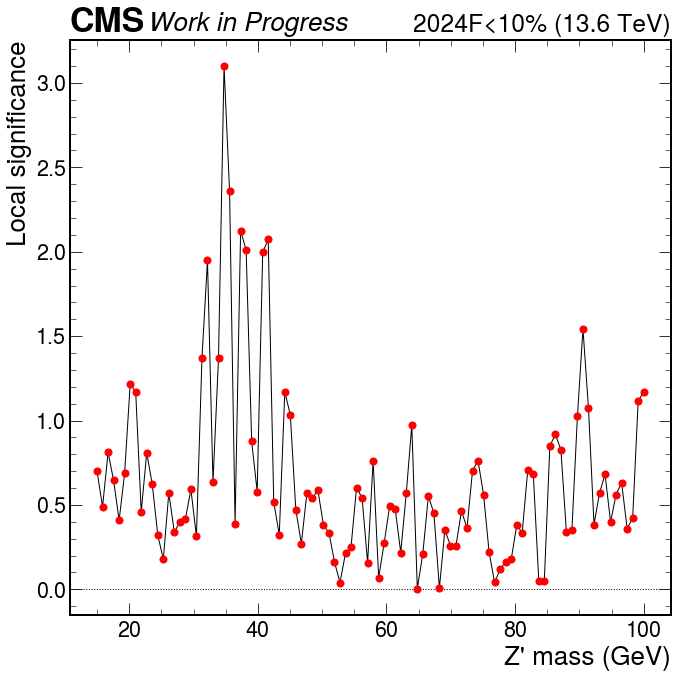

In [26]:
#Local significance using likelihood ratio

import mplhep as hep
hep.style.use('CMS')
hep.cms.label('Work in Progress', data=True, lumi=None, year="2024F<10%", com=13.6)
plt.plot(masses, local_sig, color='black', linestyle='-', linewidth=1)
plt.scatter(masses, local_sig, color='red', s=50, zorder=3) 
plt.axhline(0, color='black', linestyle='dotted', linewidth=1)

# Labels and title
plt.xlabel("Z' mass (GeV)")
plt.ylabel(r"Local significance")

# Aesthetic adjustments
plt.tight_layout()

plt.show()

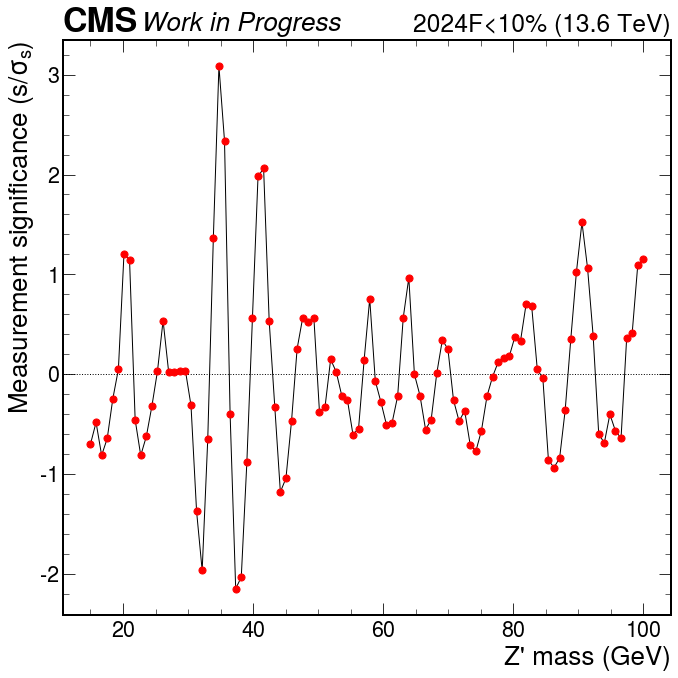

In [17]:
#Local significance using signal/(error in signal)

import mplhep as hep
hep.style.use('CMS')
hep.cms.label('Work in Progress', data=True, lumi=None, year="2024F<10%", com=13.6)
plt.plot(masses, signal_yield/signal_error, color='black', linestyle='-', linewidth=1)
plt.scatter(masses, signal_yield/signal_error, color='red', s=50, zorder=3) 
plt.axhline(0, color='black', linestyle='dotted', linewidth=1)

# Labels and title
plt.xlabel("Z' mass (GeV)")
plt.ylabel(r"Measurement significance (s/$\sigma_s$)")
#plt.title("Measurement significance vs. Z' mass", fontsize=16)

# Aesthetic adjustments
plt.grid(False)  # Disable grid to match ROOT-style
plt.tight_layout()

plt.show()


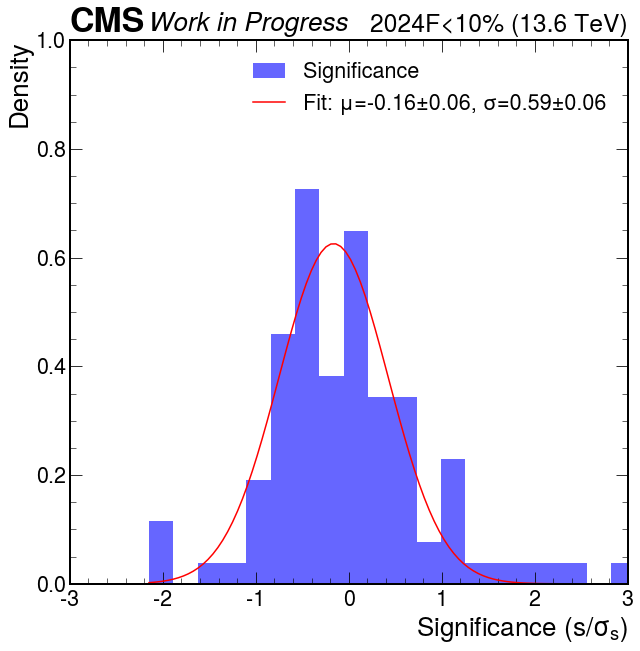

In [23]:
#1D projection of local significance

import mplhep as hep
hep.style.use('CMS')
hep.cms.label('Work in Progress', data=True, lumi=None, year="2024F<10%", com=13.6)

from scipy.stats import norm
from scipy.optimize import curve_fit

# Compute histogram
counts, bins = np.histogram(signal_yield/signal_error, bins=25, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define Gaussian function
def gaussian(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

# Fit the histogram with a Gaussian function
popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[np.mean(signal_yield/signal_error), np.std(signal_yield/signal_error), max(counts)])

mu_fit, sigma_fit, A_fit = popt
mu_err, sigma_err, A_err = np.sqrt(np.diag(pcov))  # Parameter uncertainties

# Plot the histogram and the fit
plt.hist(signal_yield/signal_error, bins=20, density=True, alpha=0.6, color='b', label="Significance")
x = np.linspace(bins[0], bins[-1], 100)
plt.plot(x, gaussian(x, *popt), 'r-', label=f'Fit: μ={mu_fit:.2f}±{mu_err:.2f}, σ={sigma_fit:.2f}±{sigma_err:.2f}')
plt.xlabel(r"Significance (s/$\sigma_s$)")
plt.ylabel("Density")
plt.ylim(0,1)
plt.xlim(-3,3)
plt.legend()
plt.show()

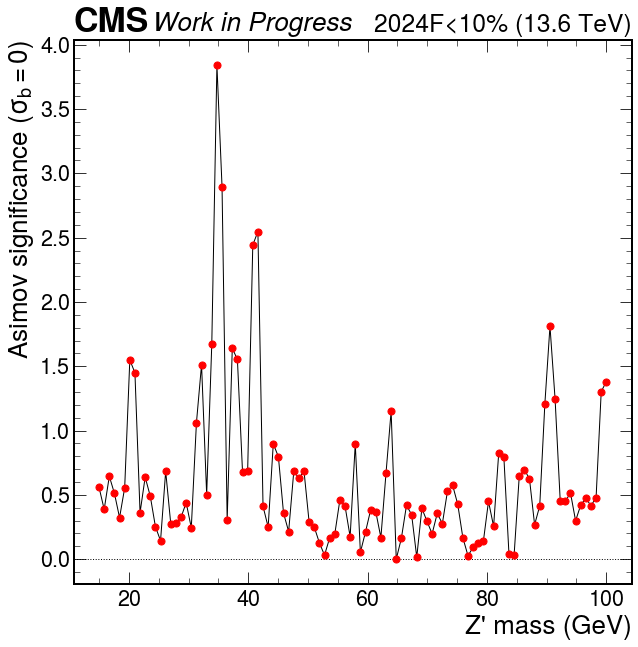

In [27]:
#Asimov significance (sigma_b = 0)

import mplhep as hep
hep.style.use('CMS')
hep.cms.label('Work in Progress', data=True, lumi=None, year="2024F<10%", com=13.6)

def significance(s,b):
    return np.sqrt(2*((s+b)*np.log((s+b)/b)-s))
signal_yield, signal_error, background_yield = np.array(signal_yield), np.array(signal_error), np.array(background_yield)
plt.plot(masses, significance(signal_yield, background_yield), color='black', linestyle='-', linewidth=1)
plt.scatter(masses, significance(signal_yield, background_yield), color='red', s=50, zorder=3) 
plt.axhline(0, color='black', linestyle='dotted', linewidth=1)

# Labels and title
plt.xlabel("Z' mass (GeV)")
plt.ylabel(r"Asimov significance ($\sigma _b=0$)")

plt.show()

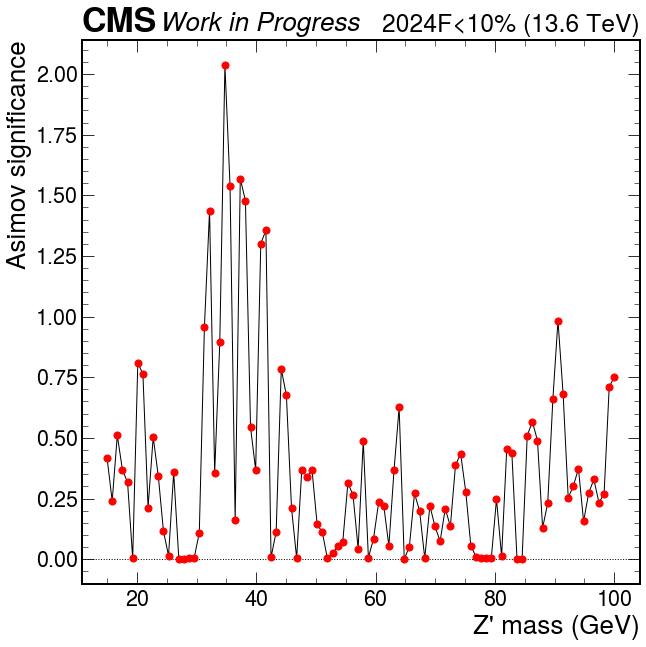

In [28]:
#Asimov significance

import mplhep as hep
hep.style.use('CMS')
hep.cms.label('Work in Progress', data=True, lumi=None, year="2024F<10%", com=13.6)

background_yield, background_error = np.array(background_yield), np.array(background_error)

def significance(s,b):
    return np.sqrt(2*((s+b)*np.log((s+b)/b)-s))
def significance(s,b,sigma_b):
    return np.sqrt(2*((s+b)*np.log((s+b)*(b+sigma_b**2)/(b**2+(s+b)*sigma_b**2))-b**2/sigma_b**2*np.log(1+sigma_b**2*s/(b*(b+sigma_b**2)))))
signal_yield, signal_error, background_yield = np.array(signal_yield), np.array(signal_error), np.array(background_yield)
plt.plot(masses, significance(signal_yield, background_yield, background_error), color='black', linestyle='-', linewidth=1)
plt.scatter(masses, significance(signal_yield, background_yield, background_error), color='red', s=50, zorder=3) 
plt.axhline(0, color='black', linestyle='dotted', linewidth=1)

# Labels and title
plt.xlabel("Z' mass (GeV)")
plt.ylabel(r"Asimov significance")

plt.show()